In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# Get co-occurences
import pandas as pd
import numpy as np
from collections import defaultdict

def co_occurrence(sentences, window_size, vocab):
    d = defaultdict(int)
    for text in sentences:
        # iterate over sentences
        for i in range(len(text)):
            token = text[i]
            if token in vocab:
                next_token = text[i+1 : i+1+window_size]
                for t in next_token:
                    if t in vocab:
                        key = tuple(sorted([t, token]))
                        d[key] += 1
    
    # formulate the dictionary into dataframe
    df = pd.DataFrame(data=np.zeros((len(vocab), len(vocab)), dtype=np.int16),
                      index=vocab,
                      columns=vocab)
    for key, value in d.items():
        df.at[key[0], key[1]] = value
        df.at[key[1], key[0]] = value
    return df

In [ ]:
import numpy as np

# Get PMI
def pmi(df, positive=True):
    col_totals = df.sum(axis=0)
    total = col_totals.sum()
    row_totals = df.sum(axis=1)
    expected = np.outer(row_totals, col_totals) / total
    df = df / expected
    # Silence distracting warnings about log(0):
    with np.errstate(divide='ignore'):
        df = np.log(df)
    df[np.isinf(df)] = 0.0  # log(0) = 0
    if positive:
        df[df < 0] = 0.0
    return df

In [ ]:
window_size = 5

In [ ]:
from gensim.models import Word2Vec
from tqdm import tqdm
from ast import literal_eval

# Collect all vocabulary
all_vocab = set()
years = [i for i in range(2000, 2020)]
for year in tqdm(years):
    model = Word2Vec.load(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Models/News/Word2vec/word2vec_{year}.model')
    vocab = model.wv.index_to_key
    all_vocab.update(vocab)

100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


In [ ]:
len(all_vocab)

19121

In [ ]:
import json

with open('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/News/Dynamic/news_all_vocab.json', 'w', encoding='utf-8') as f:
    json.dump(json.dumps(all_vocab), f)

In [ ]:
import json

with open('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/News/Dynamic/news_all_vocab.json', 'r', encoding='utf-8') as f:
    all_vocab = json.loads(json.load(f))

In [ ]:
word_to_index = {w: i for i, w in enumerate(all_vocab)}

In [ ]:
import numpy as np

# Initialize U matrix with static embeddings
years = [i for i in range(2000, 2020)]
U = [np.zeros((len(all_vocab), 300)) for t in years]

i = 0
for year in tqdm(years):
    model = Word2Vec.load(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Models/News/Word2vec/word2vec_{year}.model')
    for word in model.wv.index_to_key:
        if word not in word_to_index:
            continue
        embed = model.wv[word]
        U[i][word_to_index[word]] = embed
    i += 1
U = np.asarray(U)

In [ ]:
from sklearn.decomposition import PCA
from tqdm import tqdm

# Reduce the dimensionality of word embeddings from 300 to 50
U_new = []
for i in tqdm(range(len(U))):
    pca = PCA(n_components=50)
    fitted = pca.fit_transform(U[i])
    U_new.append(fitted)

In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/News/Dynamic/news_U_matrix.npy', 'wb') as f:
    np.save(f, U)

In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/News/Dynamic/news_U_matrix.npy', 'rb') as f:
    U = np.load(f)

In [ ]:
import pandas as pd
from gensim.models import Word2Vec
from tqdm import tqdm
from ast import literal_eval

# Compute PPMI
years = [i for i in range(2000, 2020)]
k = 0
for year in tqdm(years):
    df_temp = pd.read_csv(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/News/Dynamic/News/data_{year}.csv', compression='zip',
                              converters={'tokenized_text': literal_eval, 'lemmas': literal_eval})
    
    model = Word2Vec.load(f'/content/gdrive/MyDrive/Colab Notebooks/Theis/Models/News/Word2vec/word2vec_5w_{year}.model')
    model_vocab = set(model.wv.index_to_key)
    vocab = list(model_vocab.intersection(set(all_vocab)))                
    ppmi_df = co_occurrence(df_temp.lemmas, window_size, vocab)

    column_words = ppmi_df.columns
    ppmi_df.index = column_words
    ppmi_df = pmi(ppmi_df)
    df_list = None

    for i in tqdm(range(len(ppmi_df.index))):
        word_1 = ppmi_df.index[i]
        for j in range(i, len(column_words)):
            word_2 = column_words[j]         
            if ppmi_df[word_1][word_2] > 0:
                if df_list is None:
                    df_list = [[word_to_index[word_1], word_to_index[word_2], ppmi_df[word_1][word_2]]]
                else:
                    df_list.append([word_to_index[word_1], word_to_index[word_2], ppmi_df[word_1][word_2]])

    df = pd.DataFrame(df_list)

    compression_opts = dict(method='zip', archive_name=f'list_ppmi_{k}.csv') 
    df.to_csv(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/News/Dynamic/list_ppmi_5w_{k}.csv', index=False, compression=compression_opts)
    k += 1

Train the model

In [ ]:
# Code is based on https://github.com/yifan0sun/DynamicWord2Vec/tree/master

#utility functions for running the CD method
#loss: min 1/2 \sum_t | Yt - UtVt' |^2 + lam/2 \sum_t(|Ut|^2 + |Vt|^2) + 
#                                        tau/2 \sum_t>1(|Vt - Vt-1|^2 + |Ut - Ut-1|^2)
#                                        gam/2 \sum_t (|Ut - Vt|^2)

import numpy as np
import scipy.io as sio
import copy
def update(U,Y,Vm1,Vp1,lam,tau,gam,ind,iflag):
    
    UtU = np.dot(U.T,U) # rxr
    r = UtU.shape[0]    
    if iflag:   M   = UtU + (lam + 2*tau + gam)*np.eye(r)
    else:       M   = UtU + (lam + tau + gam)*np.eye(r)
       
    Uty = np.dot(U.T,Y) # rxb
    Ub  = U[ind,:].T   # rxb
    A   = Uty + gam*Ub + tau*(Vm1.T+Vp1.T)  # rxb
    Vhat = np.linalg.lstsq(M,A) #rxb
    return Vhat[0].T #bxr


#for the above function, the equations are to update V. So:
#Y is n X b (b = batch size)
#r = rank
#U is n X r
#Vm1 and Vp1 are bXr. so they are b rows of V, transposed

def import_static_init(T):
    with open('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/News/Dynamic/news_U_matrix.npy', 'rb') as f:
        emb = np.load(f)
    U = [copy.deepcopy(emb[t]) for t in T]
    V = [copy.deepcopy(emb[t]) for t in T]
    return U,V

def initvars(vocab_size,T,rank):
    # dictionary will store the variables U and V. tuple (t,i) indexes time t and word index i
    
    U,V = [],[]
    U.append(np.random.randn(vocab_size,rank)/np.sqrt(rank))
    V.append(np.random.randn(vocab_size,rank)/np.sqrt(rank))
    for t in range(1,T):
        U.append(U[0].copy())
        V.append(V[0].copy())
        print(t)
    return U,V
    
import pandas as pd
import scipy.sparse as ss
def getmat(f,v,rowflag):
    data = pd.read_csv(f, compression='zip')
    data = data.values
    
    X = ss.coo_matrix((data[:,2],(data[:,0],data[:,1])),shape=(v,v))
    
    if rowflag: 
        X = ss.csr_matrix(X)
        # X = X[inds,:]
    else:
        X = ss.csc_matrix(X)
        # X = X[:,inds]
    
    return X#.todense()

def getbatches(vocab,b):
    batchinds = []
    current = 0
    while current<vocab:
        inds = range(current,min(current+b,vocab))
        current = min(current+b,vocab)
        batchinds.append(inds)
    return batchinds

#   THE FOLLOWING FUNCTION TAKES A WORD ID AND RETURNS CLOSEST WORDS BY COSINE DISTANCE
from sklearn.metrics.pairwise import cosine_similarity
def getclosest(wid,U):
    C = []
    for t in range(len(U)):
        temp = U[t]
        K = cosine_similarity([temp[wid,:]],temp)
        mxinds = np.argsort(-K)
        mxinds = mxinds[0:10]
        C.append(mxinds)
    return C
        
# THE FOLLOWING FUNCTIONS COMPUTES THE REGULARIZER SCORES GIVEN U AND V ENTRIES
def compute_symscore(U,V):
    return np.linalg.norm(U-V)**2

def compute_smoothscore(U,Um1,Up1):
    X = np.linalg.norm(U-Up1)**2 + np.linalg.norm(U-Um1)**2
    return X

In [ ]:
# Code is based on https://github.com/yifan0sun/DynamicWord2Vec/tree/master

# main script for time CD 
# trainfile has lines of the form
# tok1,tok2,pmi

import numpy as np
import pickle as pickle

# PARAMETERS

nw = 19121 # number of words in vocab
T = range(20) # total number of time points
cuda = False 

trainhead = '/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/News/Dynamic/list_ppmi_' # location of training data
savehead = '/content/gdrive/MyDrive/Colab Notebooks/Thesis/Models/News/Dynamic/Results/'
    
def print_params(r,lam,tau,gam,emph,ITERS):
    
    print('rank = {}'.format(r))
    print('frob  regularizer = {}'.format(lam))
    print('time  regularizer = {}'.format(tau))
    print('symmetry regularizer = {}'.format(gam))
    print('emphasize param   = {}'.format(emph))
    print('total iterations = {}'.format(ITERS))
    
if __name__=='__main__':
    import sys
    ITERS = 20 # total passes over the data
    lam = 10 #frob regularizer
    gam = 50 # forcing regularizer
    tau = 50  # smoothing regularizer
    r   = 50  # rank
    b = nw # batch size
    emph = 1 # emphasize the nonzero

    foo = sys.argv
    for i in range(1,len(foo)):
        if foo[i]=='-r':    r = int(float(foo[i+1]))        
        if foo[i]=='-iters': ITERS = int(float(foo[i+1]))            
        if foo[i]=='-lam':    lam = float(foo[i+1])
        if foo[i]=='-tau':    tau = float(foo[i+1])
        if foo[i]=='-gam':    gam = float(foo[i+1])
        if foo[i]=='-b':    b = int(float(foo[i+1]))
        if foo[i]=='-emph': emph = float(foo[i+1])
        if foo[i]=='-check': erchk=foo[i+1]
    
        
    savefile = savehead+'L'+str(lam)+'T'+str(tau)+'G'+str(gam)+'A'+str(emph)
    
    print('starting training with following parameters')
    print_params(r,lam,tau,gam,emph,ITERS)
    print('there are a total of {} words, and {} time points'.format(nw,T))
    
    print('X*X*X*X*X*X*X*X*X')
    print('initializing')
    
    Ulist,Vlist = import_static_init(T)

    print('getting batch indices')
    if b < nw:
        b_ind = getbatches(nw,b)
    else:
        b_ind = [range(nw)]
    
    import time
    start_time = time.time()
    # sequential updates
    for iteration in range(ITERS):  
        print_params(r,lam,tau,gam,emph,ITERS)
        try:
            Ulist = pickle.load(open( "%sngU_iter%d.p" % (savefile,iteration), "rb" ) )
            Vlist = pickle.load(open( "%sngV_iter%d.p" % (savefile, iteration), "rb" ) )
            print(f'iteration {iteration} loaded succesfully')
            continue
        except(IOError):
            pass
        loss = 0
        # shuffle times
        if iteration == 0: times = T
        else: times = np.random.permutation(T)
        
        for t in range(len(times)):   # select a time
            print(f'iteration {iteration}, time {t}')
            f = trainhead + str(t) + '.csv'
            print(f)
            
            pmi = getmat(f,nw,False)

            if t == 0:
                loss_t = (1/2) * np.linalg.norm(pmi.todense() - np.dot(Ulist[t], Vlist[t].T))**2 + (gam/2) * np.linalg.norm(Ulist[t]-Vlist[t])**2 \
                          + (lam/2) * np.linalg.norm(Ulist[t])**2 + (lam/2) * np.linalg.norm(Vlist[t])**2 
            else:
                loss_t = (1/2) * np.linalg.norm(pmi.todense() - np.dot(Ulist[t], Vlist[t].T))**2 + (gam/2) * np.linalg.norm(Ulist[t]-Vlist[t])**2 \
                          + (lam/2) * np.linalg.norm(Ulist[t])**2 + (tau/2) * np.linalg.norm(Ulist[t-1] - Ulist[t])**2 \
                          + (lam/2) * np.linalg.norm(Vlist[t])**2 + (tau/2) * np.linalg.norm(Vlist[t-1] - Vlist[t])**2
            loss += loss_t    

            for j in range(len(b_ind)): # select a mini batch
                print(f'{j} out of {len(b_ind)}')
                ind = b_ind[j]
                ## UPDATE V
                # get data
                pmi_seg = pmi[:,ind].todense()
                
                if t==0:
                    vp = np.zeros((len(ind),r))
                    up = np.zeros((len(ind),r))
                    iflag = True
                else:
                    vp = Vlist[t-1][ind,:]
                    up = Ulist[t-1][ind,:]
                    iflag = False

                if t==len(T)-1:
                    vn = np.zeros((len(ind),r))
                    un = np.zeros((len(ind),r))
                    iflag = True
                else:
                    vn = Vlist[t+1][ind,:]
                    un = Ulist[t+1][ind,:]
                    iflag = False
                Vlist[t][ind,:] = update(Ulist[t],emph*pmi_seg,vp,vn,lam,tau,gam,ind,iflag)
                Ulist[t][ind,:] = update(Vlist[t],emph*pmi_seg,up,un,lam,tau,gam,ind,iflag)
            
            ####  INNER BATCH LOOP END
                
        # save
        print('time elapsed = ', time.time()-start_time)

        print(f'Loss {loss}')
       

        pickle.dump(Ulist, open( "%sngU_iter%d.p" % (savefile,iteration), "wb" ) , pickle.HIGHEST_PROTOCOL)
        pickle.dump(Vlist, open( "%sngV_iter%d.p" % (savefile, iteration), "wb" ) , pickle.HIGHEST_PROTOCOL)

starting training with following parameters
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 20
there are a total of 19121 words, and range(0, 20) time points
X*X*X*X*X*X*X*X*X
initializing
getting batch indices
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 20
iteration 0, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_0.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 0, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_1.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 0, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_2.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 0, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_3.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 0, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_4.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 0, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_5.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 0, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_6.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 0, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_7.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 0, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_8.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 0, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_9.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 0, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_10.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 0, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_11.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 0, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_12.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 0, time 13
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_13.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 0, time 14
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_14.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 0, time 15
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_15.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 0, time 16
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_16.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 0, time 17
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_17.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 0, time 18
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_18.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 0, time 19
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_19.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  633.1271402835846
Loss 1850507168.1180592
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 20
iteration 1, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_0.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 1, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_1.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 1, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_2.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 1, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_3.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 1, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_4.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 1, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_5.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 1, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_6.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 1, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_7.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 1, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_8.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 1, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_9.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 1, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_10.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 1, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_11.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 1, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_12.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 1, time 13
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_13.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 1, time 14
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_14.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 1, time 15
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_15.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 1, time 16
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_16.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 1, time 17
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_17.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 1, time 18
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_18.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 1, time 19
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_19.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  1277.1012344360352
Loss 145433043.8644129
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 20
iteration 2, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_0.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 2, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_1.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 2, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_2.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 2, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_3.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 2, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_4.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 2, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_5.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 2, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_6.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 2, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_7.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 2, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_8.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 2, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_9.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 2, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_10.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 2, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_11.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 2, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_12.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 2, time 13
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_13.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 2, time 14
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_14.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 2, time 15
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_15.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 2, time 16
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_16.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 2, time 17
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_17.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 2, time 18
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_18.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 2, time 19
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_19.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  1934.5966069698334
Loss 139109057.13636172
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 20
iteration 3, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_0.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 3, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_1.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 3, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_2.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 3, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_3.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 3, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_4.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 3, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_5.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 3, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_6.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 3, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_7.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 3, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_8.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 3, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_9.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 3, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_10.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 3, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_11.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 3, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_12.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 3, time 13
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_13.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 3, time 14
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_14.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 3, time 15
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_15.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 3, time 16
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_16.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 3, time 17
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_17.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 3, time 18
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_18.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 3, time 19
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_19.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  2607.5020880699158
Loss 138084350.4950293
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 20
iteration 4, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_0.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 4, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_1.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 4, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_2.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 4, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_3.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 4, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_4.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 4, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_5.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 4, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_6.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 4, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_7.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 4, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_8.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 4, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_9.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 4, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_10.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 4, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_11.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 4, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_12.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 4, time 13
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_13.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 4, time 14
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_14.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 4, time 15
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_15.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 4, time 16
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_16.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 4, time 17
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_17.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 4, time 18
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_18.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 4, time 19
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_19.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  3328.170609474182
Loss 138555660.41883674
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 20
iteration 5, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_0.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 5, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_1.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 5, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_2.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 5, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_3.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 5, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_4.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 5, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_5.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 5, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_6.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 5, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_7.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 5, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_8.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 5, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_9.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 5, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_10.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 5, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_11.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 5, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_12.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 5, time 13
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_13.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 5, time 14
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_14.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 5, time 15
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_15.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 5, time 16
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_16.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 5, time 17
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_17.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 5, time 18
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_18.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 5, time 19
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_19.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  4067.0762963294983
Loss 138779140.70860243
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 20
iteration 6, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_0.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 6, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_1.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 6, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_2.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 6, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_3.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 6, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_4.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 6, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_5.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 6, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_6.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 6, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_7.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 6, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_8.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 6, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_9.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 6, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_10.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 6, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_11.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 6, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_12.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 6, time 13
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_13.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 6, time 14
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_14.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 6, time 15
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_15.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 6, time 16
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_16.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 6, time 17
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_17.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 6, time 18
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_18.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 6, time 19
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_19.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  4809.760560035706
Loss 138700431.25659588
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 20
iteration 7, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_0.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 7, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_1.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 7, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_2.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 7, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_3.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 7, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_4.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 7, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_5.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 7, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_6.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 7, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_7.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 7, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_8.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 7, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_9.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 7, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_10.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 7, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_11.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 7, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_12.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 7, time 13
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_13.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 7, time 14
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_14.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 7, time 15
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_15.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 7, time 16
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_16.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 7, time 17
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_17.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 7, time 18
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_18.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 7, time 19
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_19.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  5574.902006387711
Loss 138617282.29405576
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 20
iteration 8, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_0.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 8, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_1.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 8, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_2.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 8, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_3.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 8, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_4.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 8, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_5.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 8, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_6.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 8, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_7.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 8, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_8.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 8, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_9.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 8, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_10.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 8, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_11.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 8, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_12.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 8, time 13
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_13.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 8, time 14
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_14.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 8, time 15
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_15.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 8, time 16
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_16.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 8, time 17
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_17.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 8, time 18
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_18.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 8, time 19
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_19.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  6353.199947357178
Loss 138567864.4699289
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 20
iteration 9, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_0.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 9, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_1.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 9, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_2.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 9, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_3.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 9, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_4.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 9, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_5.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 9, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_6.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 9, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_7.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 9, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_8.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 9, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_9.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 9, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_10.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 9, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_11.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 9, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_12.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 9, time 13
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_13.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 9, time 14
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_14.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 9, time 15
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_15.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 9, time 16
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_16.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 9, time 17
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_17.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 9, time 18
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_18.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 9, time 19
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_19.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  7148.471368789673
Loss 138487512.61467034
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 20
iteration 10, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_0.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 10, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_1.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 10, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_2.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 10, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_3.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 10, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_4.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 10, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_5.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 10, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_6.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 10, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_7.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 10, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_8.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 10, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_9.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 10, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_10.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 10, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_11.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 10, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_12.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 10, time 13
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_13.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 10, time 14
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_14.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 10, time 15
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_15.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 10, time 16
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_16.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 10, time 17
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_17.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 10, time 18
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_18.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 10, time 19
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_19.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  7930.424453020096
Loss 138435187.13381237
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 20
iteration 11, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_0.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 11, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_1.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 11, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_2.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 11, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_3.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 11, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_4.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 11, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_5.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 11, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_6.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 11, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_7.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 11, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_8.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 11, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_9.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 11, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_10.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 11, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_11.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 11, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_12.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 11, time 13
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_13.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 11, time 14
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_14.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 11, time 15
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_15.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 11, time 16
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_16.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 11, time 17
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_17.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 11, time 18
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_18.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 11, time 19
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_19.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  8724.774006605148
Loss 138415994.42097127
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 20
iteration 12, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_0.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 12, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_1.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 12, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_2.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 12, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_3.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 12, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_4.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 12, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_5.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 12, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_6.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 12, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_7.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 12, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_8.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 12, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_9.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 12, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_10.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 12, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_11.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 12, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_12.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 12, time 13
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_13.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 12, time 14
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_14.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 12, time 15
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_15.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 12, time 16
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_16.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 12, time 17
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_17.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 12, time 18
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_18.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 12, time 19
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_19.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  9547.261503219604
Loss 138409337.83447948
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 20
iteration 13, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_0.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 13, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_1.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 13, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_2.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 13, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_3.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 13, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_4.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 13, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_5.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 13, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_6.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 13, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_7.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 13, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_8.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 13, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_9.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 13, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_10.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 13, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_11.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 13, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_12.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 13, time 13
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_13.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 13, time 14
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_14.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 13, time 15
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_15.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 13, time 16
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_16.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 13, time 17
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_17.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 13, time 18
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_18.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 13, time 19
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_19.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  10368.895357608795
Loss 138395576.41388893
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 20
iteration 14, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_0.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 14, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_1.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 14, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_2.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 14, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_3.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 14, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_4.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 14, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_5.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 14, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_6.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 14, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_7.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 14, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_8.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 14, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_9.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 14, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_10.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 14, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_11.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 14, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_12.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 14, time 13
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_13.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 14, time 14
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_14.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 14, time 15
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_15.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 14, time 16
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_16.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 14, time 17
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_17.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 14, time 18
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_18.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 14, time 19
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_19.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  11182.567760705948
Loss 138385945.84326258
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 20
iteration 15, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_0.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 15, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_1.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 15, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_2.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 15, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_3.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 15, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_4.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 15, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_5.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 15, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_6.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 15, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_7.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 15, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_8.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 15, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_9.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 15, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_10.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 15, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_11.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 15, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_12.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 15, time 13
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_13.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 15, time 14
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_14.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 15, time 15
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_15.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 15, time 16
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_16.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 15, time 17
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_17.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 15, time 18
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_18.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 15, time 19
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_19.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  11991.558547258377
Loss 138409655.81294093
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 20
iteration 16, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_0.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 16, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_1.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 16, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_2.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 16, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_3.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 16, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_4.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 16, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_5.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 16, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_6.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 16, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_7.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 16, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_8.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 16, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_9.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 16, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_10.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 16, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_11.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 16, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_12.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 16, time 13
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_13.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 16, time 14
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_14.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 16, time 15
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_15.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 16, time 16
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_16.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 16, time 17
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_17.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 16, time 18
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_18.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 16, time 19
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_19.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  12804.317681789398
Loss 138424942.26857302
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 20
iteration 17, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_0.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 17, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_1.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 17, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_2.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 17, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_3.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 17, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_4.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 17, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_5.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 17, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_6.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 17, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_7.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 17, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_8.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 17, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_9.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 17, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_10.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 17, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_11.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 17, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_12.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 17, time 13
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_13.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 17, time 14
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_14.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 17, time 15
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_15.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 17, time 16
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_16.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 17, time 17
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_17.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 17, time 18
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_18.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 17, time 19
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_19.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  13608.743327140808
Loss 138426125.88325968
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 20
iteration 18, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_0.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 18, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_1.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 18, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_2.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 18, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_3.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 18, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_4.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 18, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_5.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 18, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_6.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 18, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_7.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 18, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_8.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 18, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_9.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 18, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_10.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 18, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_11.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 18, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_12.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 18, time 13
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_13.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 18, time 14
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_14.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 18, time 15
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_15.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 18, time 16
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_16.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 18, time 17
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_17.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 18, time 18
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_18.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 18, time 19
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_19.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  14426.139220952988
Loss 138436029.5566662
rank = 50
frob  regularizer = 10
time  regularizer = 50
symmetry regularizer = 50
emphasize param   = 1
total iterations = 20
iteration 19, time 0
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_0.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 19, time 1
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_1.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 19, time 2
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_2.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 19, time 3
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_3.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 19, time 4
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_4.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 19, time 5
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_5.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 19, time 6
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_6.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 19, time 7
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_7.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 19, time 8
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_8.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 19, time 9
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_9.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 19, time 10
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_10.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 19, time 11
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_11.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 19, time 12
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_12.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 19, time 13
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_13.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 19, time 14
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_14.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 19, time 15
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_15.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 19, time 16
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_16.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 19, time 17
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_17.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 19, time 18
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_18.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


iteration 19, time 19
/content/gdrive/MyDrive/Colab Notebooks/Final/Data/News/list_ppmi_19.csv
0 out of 1


<ipython-input-5-a39c1499620e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Vhat = np.linalg.lstsq(M,A) #rxb


time elapsed =  15240.949778556824
Loss 138426636.4123265


Find the words that experienced the most significant semantic shift

In [ ]:
import json

with open('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/News/Dynamic/news_all_vocab.json', 'r', encoding='utf-8') as f:
    all_vocab = json.loads(json.load(f))

In [ ]:
word_to_index = {w: i for i, w in enumerate(all_vocab)}

In [ ]:
import json

with open('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/News/Common/shared_words_news.json', 'r') as f:
    words = json.load(f)
words = [w[0] for w in words.items()]
words_ids = [word_to_index[w] for w in words if w in word_to_index]

In [ ]:
import pandas as pd
import numpy as np
import scipy.sparse as ss
import pickle as pickle

savehead = '/content/gdrive/MyDrive/Colab Notebooks/Thesis/Models/News/Dynamic/Results/'
lam = 10 #frob regularizer
gam = 50 # forcing regularizer
tau = 50  # smoothing regularizer
emph = 1 # emphasize the nonzero
savefile = savehead+'L'+str(lam)+'T'+str(tau)+'G'+str(gam)+'A'+str(emph)
iteration = 19
Ulist = pickle.load(open( "%sngU_iter%d.p" % (savefile,iteration), "rb" ) )

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

cosine_similarities ={}

for w_id in tqdm(words_ids):
    embed_1 = Ulist[0][w_id]
    embed_2 = Ulist[19][w_id]
    cosine_similarities[(all_vocab[w_id], w_id)] = cosine_similarity([embed_1], 
                                                  [embed_2])[0][0]

100%|██████████| 4064/4064 [00:01<00:00, 2519.79it/s]


In [ ]:
top_20 = sorted(cosine_similarities.items(), key=lambda item: abs(item[1]))[:20]
top_20

[(('лауреат', 7320), -0.0001912994772371307),
 (('свадьба', 14418), -0.00022309301146813953),
 (('франциско', 17596), 0.0002477466281872601),
 (('уважение', 16783), 0.00034091389001868547),
 (('турист', 16675), 0.0004511405579186757),
 (('аргумент', 667), -0.00046316868896501446),
 (('законодатель', 4866), 0.000539140807321813),
 (('ясно', 19106), -0.0006021113672614199),
 (('повстанец', 11510), -0.0006832440759256229),
 (('хиллари', 17843), 0.0007297012971693925),
 (('грабитель', 3391), -0.0007445921995054266),
 (('тайный', 16042), -0.0007890173412822103),
 (('торговец', 16424), -0.0008094673213264311),
 (('долго', 4205), 0.0008136706139446996),
 (('егор', 4507), -0.0009297376858546642),
 (('частота', 18185), 0.0011265968453885791),
 (('успех', 17172), 0.0013525757139426129),
 (('обломок', 9839), -0.0013622475577178984),
 (('достигнутый', 4299), -0.0013852893901018688),
 (('полотно', 11893), 0.0014129309209448306)]

In [ ]:
def getclosest(wid, U, y1, y2):
    C = []
    temp_1 = U[y1]
    temp_2 = U[y2]
    K = cosine_similarity([temp_1[wid,:]],temp_2)
    mxinds = np.argsort(-abs(K[0]))
    mxinds = mxinds[0:10]
    return mxinds

In [ ]:
for word in top_20:
    print(word[0][0])
    closest_2000 = getclosest(word[0][1],Ulist, 0, 0)
    w_closest_2000  = [all_vocab[i] for i in closest_2000]
    print(w_closest_2000)
    closest_2019 = getclosest(word[0][1],Ulist, 19, 19)
    w_closest_2019  = [all_vocab[i] for i in closest_2019]
    print(w_closest_2019)

лауреат
['лауреат', 'жюри', 'номинация', 'театральный', 'артист', 'оскар', 'художественный', 'спектакль', 'вручить', 'доктор']
['лауреат', 'театральный', 'вручение', 'жюри', 'почётный', 'кинематографист', 'заслужить', 'документальный', 'наградить', 'орден']
свадьба
['свадьба', 'мадонна', 'принцесса', 'леннон', 'рождество', 'любимый', 'поклонник', 'принц', 'семейный', 'голливуд']
['свадьба', 'принц', 'телеведущий', 'гарри', 'невеста', 'комментатор', 'принцесса', 'ким', 'уильям', 'кейт']
франциско
['франциско', 'чикаго', 'галерея', 'анджелес', 'кеннеди', 'техас', 'хьюстон', 'парка', 'цюрих', 'флорида']
['франциско', 'сидней', 'шанхай', 'майами', 'амстердам', 'сеул', 'дубай', 'филадельфия', 'женева', 'дели']
уважение
['уважение', 'нация', 'добрый', 'противоречие', 'дух', 'вера', 'религия', 'глубокий', 'понимание', 'демократия']
['уважение', 'убедить', 'хотеться', 'посетовать', 'пусть', 'пожелать', 'добрый', 'правильно', 'бог', 'выражать']
турист
['турист', 'посадка', 'совершать', 'груз', 

100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


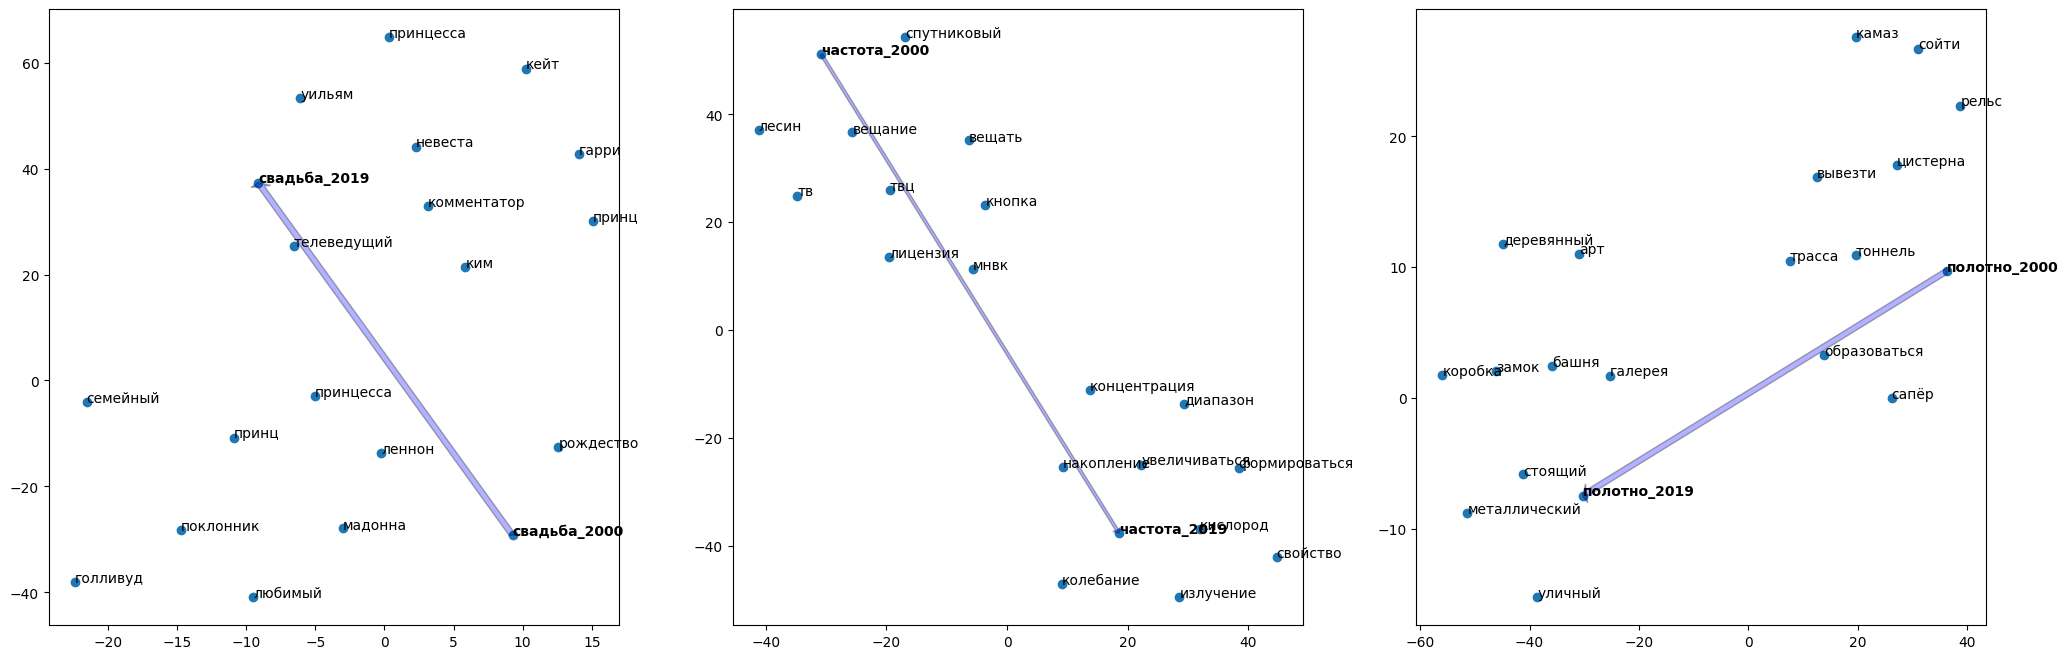

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

words = ['свадьба', 'частота', 'полотно']
years = [2000, 2019]

vectors_2000 = Ulist[0]
vectors_2019 = Ulist[19]

points = []
all_keys = []

for word in tqdm(words):
    wid = word_to_index[word]
    K_2000 = cosine_similarity([vectors_2000[wid,:]],vectors_2000)
    K_2019 = cosine_similarity([vectors_2019[wid,:]],vectors_2019)

    mxinds_2000 = np.argsort(-abs(K_2000[0]))
    mxinds_2000 = mxinds_2000[0:10]

    mxinds_2019 = np.argsort(-abs(K_2019[0]))
    mxinds_2019 = mxinds_2019[0:10]

    w_closest_2000  = [all_vocab[i] for i in mxinds_2000[1:]]
    w_closest_2019  = [all_vocab[i] for i in mxinds_2019[1:]]

    all_words = w_closest_2000
    all_words.extend(w_closest_2019)
    all_words.extend([f'{word}_2000', f'{word}_2019'])

    embeds_2000 = [vectors_2000[i] for i in mxinds_2000[1:]]
    embeds_2019 = [vectors_2019[i] for i in mxinds_2019[1:]]

    all_embeds = embeds_2000
    all_embeds.extend(embeds_2019)
    all_embeds.extend([vectors_2000[wid], vectors_2019[wid]])

    # Fit t-SNE
    mat = np.array(all_embeds)
    model = TSNE(n_components=2, random_state=0, init='pca', perplexity=10)
    fitted = model.fit_transform(mat)
    points.append(fitted)
    all_keys.append(all_words)

fig, ax = plt.subplots(1, 3)

fig.set_figheight(8)
fig.set_figwidth(25)

for j in range(3):
    fitted = points[j]
    x = fitted[:, 0]
    y = fitted[:, 1]
    keys = all_keys[j]

    ax[j].scatter(x, y)

    for i, txt in enumerate(keys):
        if len(keys) - i <= 2:
            ax[j].annotate(txt, (x[i], y[i]), weight='bold')
        else:
            ax[j].annotate(txt, (x[i], y[i]))
    
    ax[j].arrow(fitted[-2, 0], fitted[-2, 1], (fitted[-1, 0] - fitted[-2, 0]), 
              (fitted[-1, 1] - fitted[-2, 1]), facecolor='blue', alpha=0.3, width=0.5,
              head_length=0.75, length_includes_head=True)
fig.savefig(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Vectors/news_dyn.png')